In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jacfwd, jacrev
import os
from IPython.display import Image

# JAXで生成した計算グラフを可視化する
教科書2.4.2節(2.28)式
$$
f(x_1,x_2) = (x_1 + x_2)x_1^2$$
の$x_1$による偏微分を具体例にやってみる

[参考](https://bnikolic.co.uk/blog/python/jax/2022/02/22/jax-outputgraph-rev.html)

In [7]:
save_dir = "./out"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [8]:
# 教科書2.4.2の計算
@jax.jit
def f(x1, x2):
    return (x1 + x2) * x1**2

In [32]:
def gen_dot(func, inputs, name = "test"):
    z = jax.xla_computation(func)(*inputs)
    save_name = os.path.join(save_dir, name + ".dot")
    with open(save_name, "w") as file:
        file.write(z.as_hlo_dot_graph())
    return save_name

def gen_fig(save_name):
    convert_name = save_name[:-4] + ".png"    
    os.system("dot {} -Tpng > {}".format(save_name, convert_name));
    return convert_name

In [33]:
inputs = [1.0, 2.0]
name = "test_cg_f"
save_name = gen_dot(f, inputs, name)
convert_name = gen_fig(save_name)

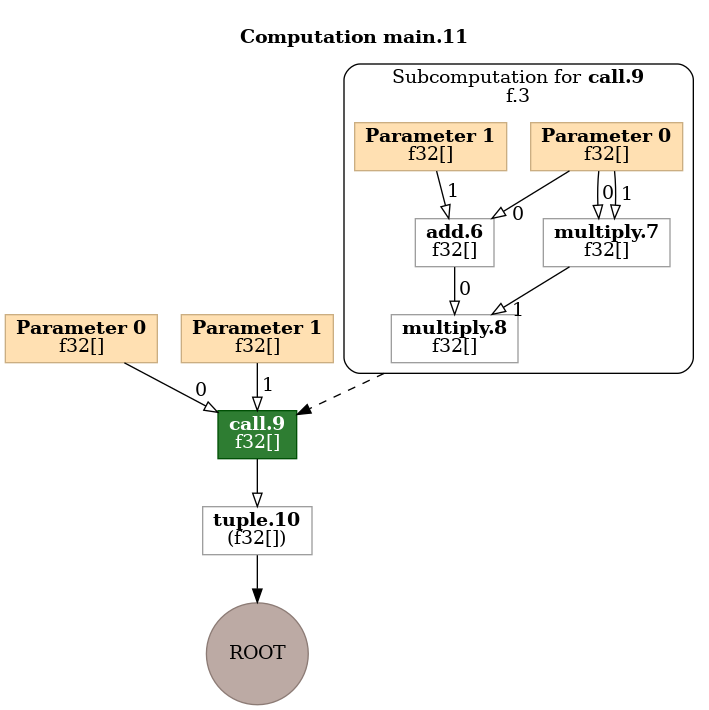

In [34]:
Image(convert_name)

In [14]:
print(jax.make_jaxpr(f)(*inputs))

{ lambda ; a:f32[] b:f32[]. let
    c:f32[] = pjit[
      name=f
      jaxpr={ lambda ; d:f32[] e:f32[]. let
          f:f32[] = add d e
          g:f32[] = integer_pow[y=2] d
          h:f32[] = mul f g
        in (h,) }
    ] a b
  in (c,) }


In [15]:
df = grad(f, argnums=0) #x1での偏微分

In [16]:
name = "test_cg_df"
save_name = gen_dot(df, inputs, name)
convert_name = gen_fig(save_name)

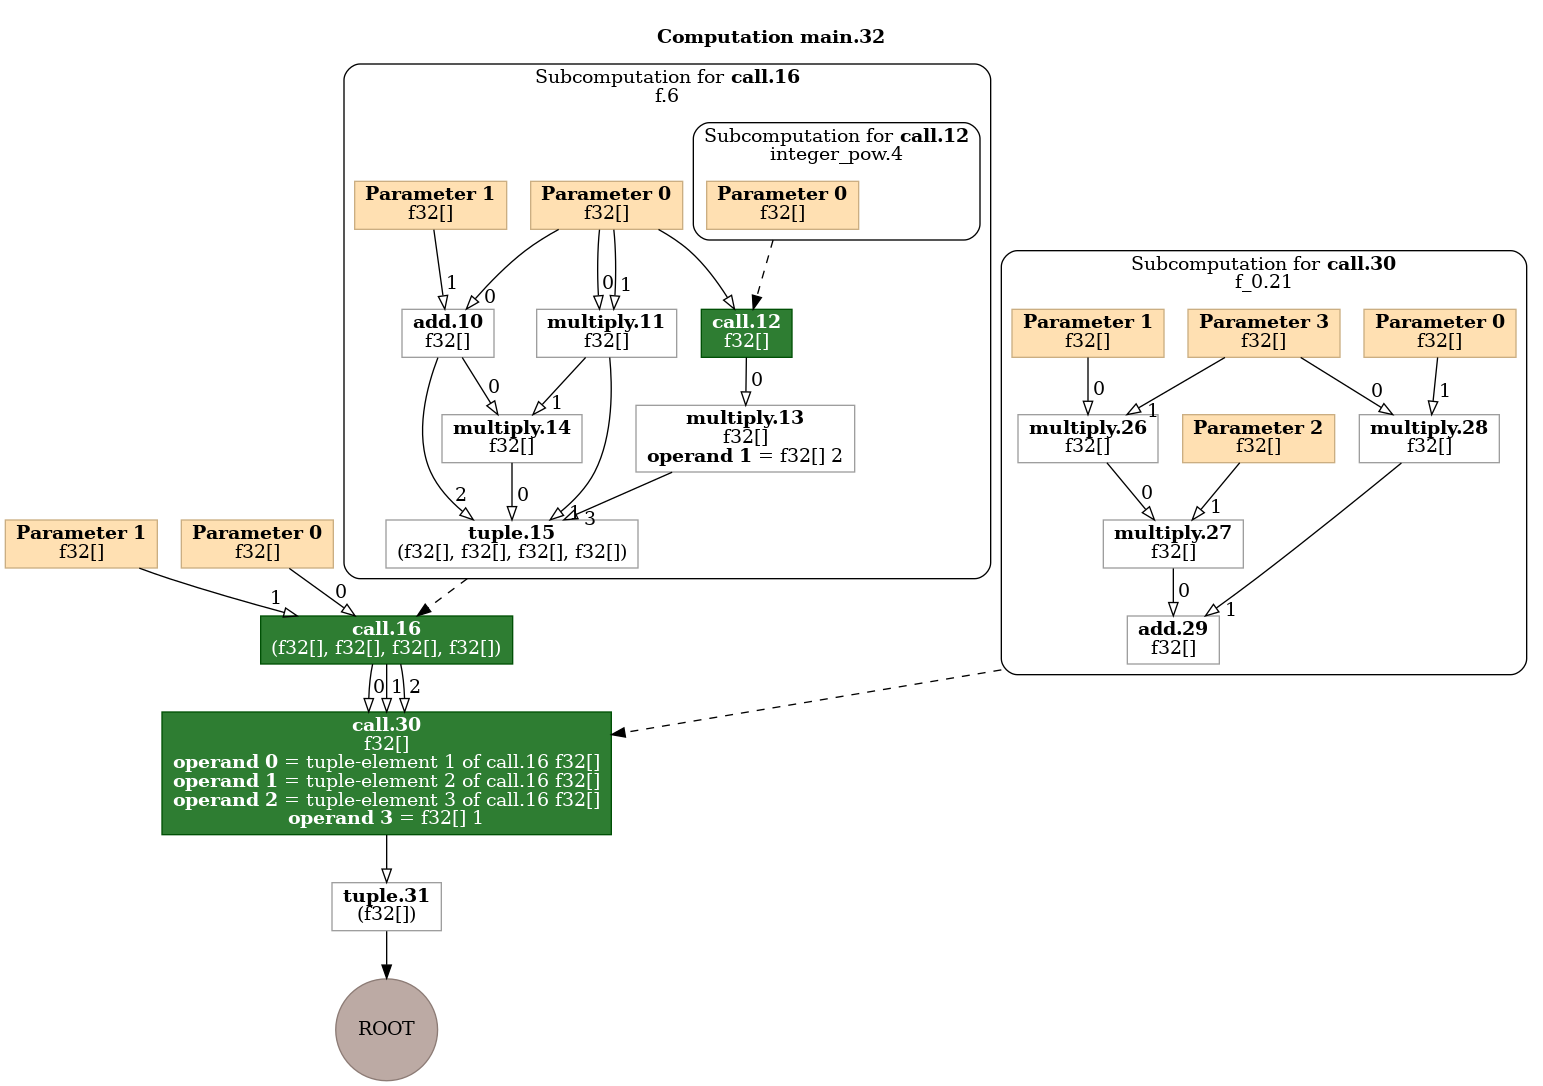

In [17]:
Image(convert_name)

In [18]:
print(jax.make_jaxpr(df)(*inputs))

{ lambda ; a:f32[] b:f32[]. let
    _:f32[] c:f32[] d:f32[] e:f32[] = pjit[
      name=f
      jaxpr={ lambda ; f:f32[] g:f32[]. let
          h:f32[] = add f g
          i:f32[] = integer_pow[y=2] f
          j:f32[] = integer_pow[y=1] f
          k:f32[] = mul 2.0 j
          l:f32[] = mul h i
        in (l, i, h, k) }
    ] a b
    m:f32[] = pjit[
      name=f
      jaxpr={ lambda ; n:f32[] o:f32[] p:f32[] q:f32[]. let
          r:f32[] = mul o q
          s:f32[] = mul r p
          t:f32[] = mul q n
          u:f32[] = add_any s t
        in (u,) }
    ] c d e 1.0
  in (m,) }


# 順方向自動微分と逆方向自動微分
- `grad()`は逆方向自動微分っぽいが
- ベクトルで微分したり、ベクトルを微分する（ヤコビアン求める）のに使える`jacfwd`と`jacrev`はそれぞれ順方向自動微分、逆方向自動微分となっているっぽい
- 二次勾配（ヘシアン）を求めるときはこれらを組み合わせると効率的らしい→https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#jacobians-and-hessians-using-jacfwd-and-jacrev

## 順方向自動微分

In [21]:
df_fwd = jacfwd(f, argnums=0) #x1での偏微分

In [22]:
name = "test_cg_df_fwd"
save_name = gen_dot(df_fwd, inputs, name)
convert_name = gen_fig(save_name)

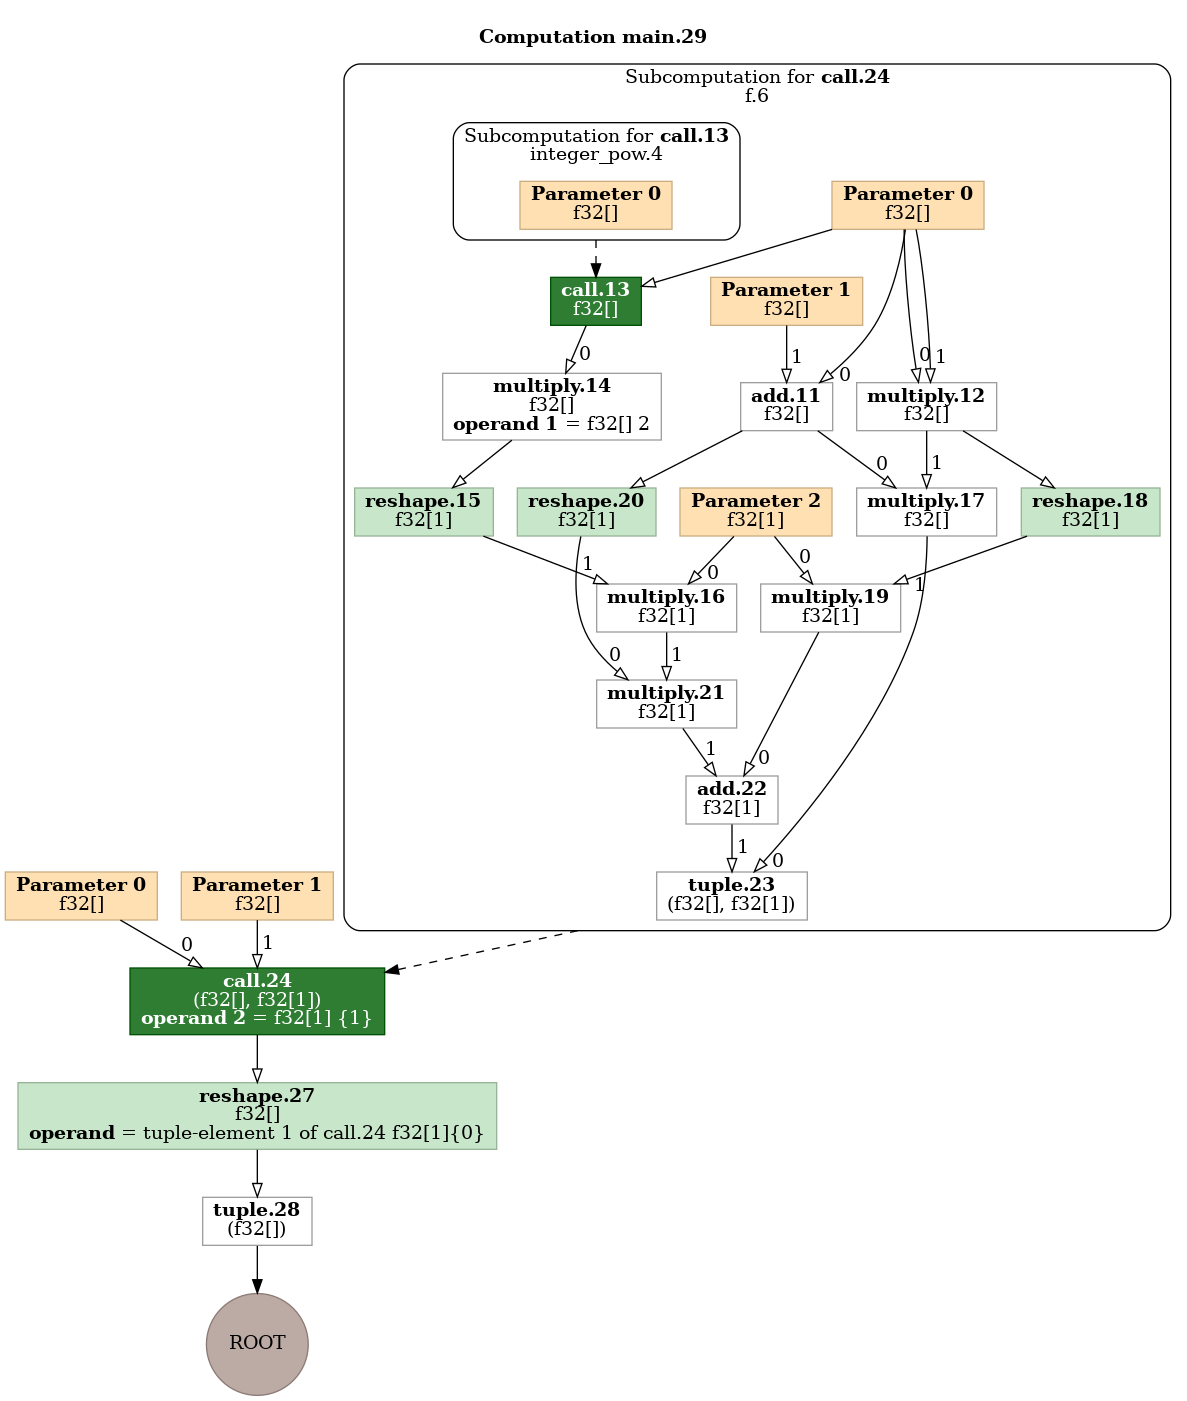

In [23]:
Image(convert_name)

In [25]:
print(jax.make_jaxpr(df_fwd)(*inputs))

{ lambda ; a:f32[] b:f32[]. let
    c:i32[1,1] = iota[dimension=0 dtype=int32 shape=(1, 1)] 
    d:i32[1,1] = add c 0
    e:i32[1,1] = iota[dimension=1 dtype=int32 shape=(1, 1)] 
    f:bool[1,1] = eq d e
    g:f32[1,1] = convert_element_type[new_dtype=float32 weak_type=False] f
    h:f32[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] g
    i:f32[1] = reshape[dimensions=None new_sizes=(1,)] h
    j:f32[1] = convert_element_type[new_dtype=float32 weak_type=True] i
    _:f32[] k:f32[1] = pjit[
      name=f
      jaxpr={ lambda ; l:f32[] m:f32[] n:f32[1]. let
          o:f32[] = add l m
          p:f32[] = integer_pow[y=2] l
          q:f32[] = integer_pow[y=1] l
          r:f32[] = mul 2.0 q
          s:f32[1] = mul n r
          t:f32[] = mul o p
          u:f32[1] = mul n p
          v:f32[1] = mul o s
          w:f32[1] = add_any u v
        in (t, w) }
    ] a b j
    x:f32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=None] k
    y:f32[] = reshape[dim

## 逆方向自動微分

In [26]:
df_rev = jacrev(f, argnums=0) #x1での偏微分

In [27]:
name = "test_cg_df_rev"
save_name = gen_dot(df_rev, inputs, name)
convert_name = gen_fig(save_name)

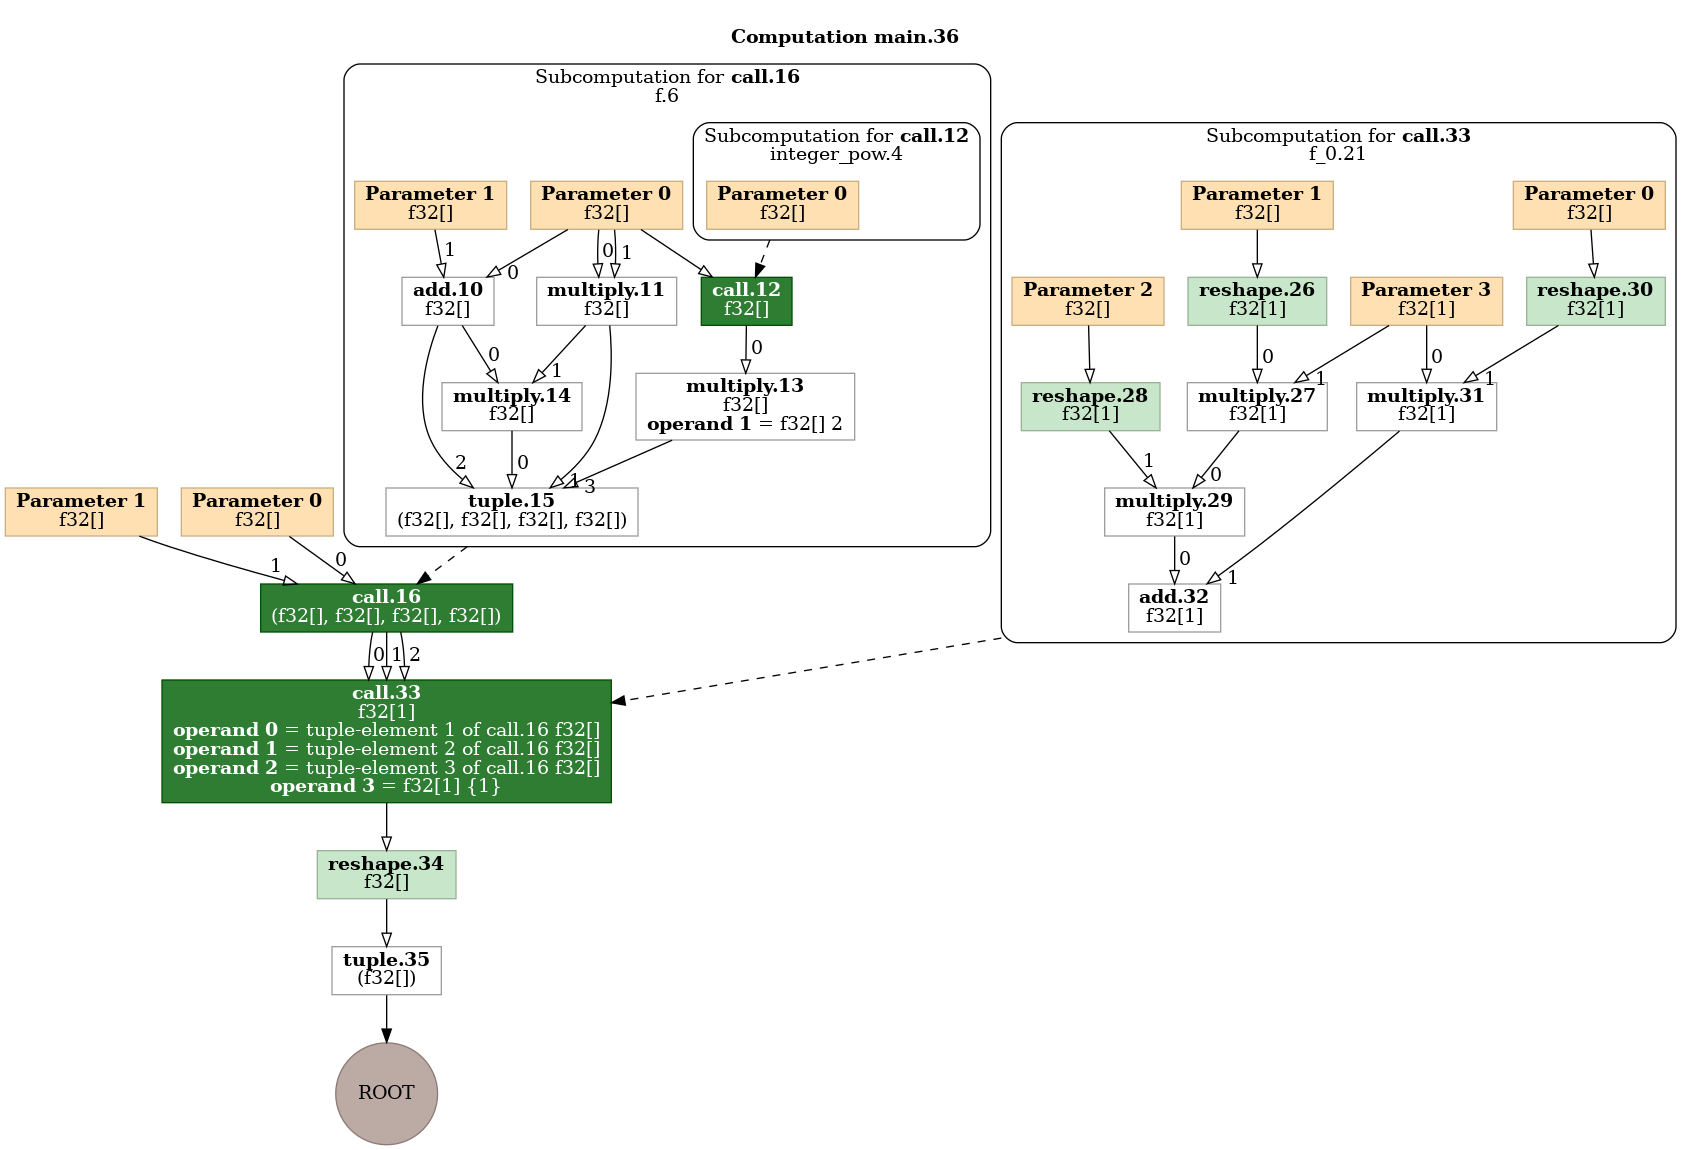

In [28]:
Image(convert_name)

In [29]:
print(jax.make_jaxpr(df_rev)(*inputs))

{ lambda ; a:f32[] b:f32[]. let
    _:f32[] c:f32[] d:f32[] e:f32[] = pjit[
      name=f
      jaxpr={ lambda ; f:f32[] g:f32[]. let
          h:f32[] = add f g
          i:f32[] = integer_pow[y=2] f
          j:f32[] = integer_pow[y=1] f
          k:f32[] = mul 2.0 j
          l:f32[] = mul h i
        in (l, i, h, k) }
    ] a b
    m:i32[1,1] = iota[dimension=0 dtype=int32 shape=(1, 1)] 
    n:i32[1,1] = add m 0
    o:i32[1,1] = iota[dimension=1 dtype=int32 shape=(1, 1)] 
    p:bool[1,1] = eq n o
    q:f32[1,1] = convert_element_type[new_dtype=float32 weak_type=False] p
    r:f32[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] q
    s:f32[1] = reshape[dimensions=None new_sizes=(1,)] r
    t:f32[1] = convert_element_type[new_dtype=float32 weak_type=True] s
    u:f32[1] = pjit[
      name=f
      jaxpr={ lambda ; v:f32[] w:f32[] x:f32[] y:f32[1]. let
          z:f32[1] = mul w y
          ba:f32[1] = mul z x
          bb:f32[1] = mul y v
          bc:f32[1] = add_

`jacrev()`は中にreshapeとかが入ってて、それらのおかげで、ベクトルでの微分ができてるかんじ？

In [31]:
print(df(*inputs), df_fwd(*inputs), df_rev(*inputs)) #同じ結果

7.0 7.0 7.0
